<a href="https://colab.research.google.com/github/shrutishibu/python-and-statistics-for-financial-analysis/blob/main/Python_and_Statistics_for_Financial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple trading strategy using moving averages

In [36]:
#required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
#displays plot within the notebook

In [37]:
#read from csv files and store as dataframes
fb = pd.read_csv('/facebook.csv')
fb.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-31,20.400000,20.510000,19.990000,20.049999,19.459270,4157500
1,2015-01-02,20.129999,20.280001,19.809999,20.129999,19.536913,2842000
2,2015-01-05,20.129999,20.190001,19.700001,19.790001,19.206934,4948800
3,2015-01-06,19.820000,19.840000,19.170000,19.190001,18.624611,4944100
4,2015-01-07,19.330000,19.500000,19.080000,19.139999,18.576082,8045200


In [39]:
#moving averages for simple trading strategy
fb['MA10'] = fb['Close'].rolling(window=10).mean() #fast signal
fb['MA50'] = fb['Close'].rolling(window=50).mean() #slow signal
fb = fb.dropna().copy()
#generate trading signals: long (1) if MA10 > MA50, otherwise 0
fb.loc[:,'Shares'] = (fb['MA10'] > fb['MA50']).astype(int)
#add a column for the next day's closing prices
fb.loc[:,'Close1'] = fb['Close'].shift(-1)
#calculate profit: difference in closing prices if long, otherwise 0
fb.loc[:,'Profit'] = (fb['Close1'] - fb['Close']).where(fb['Shares'] == 1, 0)
fb.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA50,Shares,Close1,Profit
98,2015-05-22,20.940001,21.020000,20.809999,20.860001,20.417433,5314800,21.010,21.9398,0,20.730000,0.0
99,2015-05-26,20.760000,20.900000,20.570000,20.730000,20.290192,6493300,21.020,21.9004,0,21.840000,0.0
100,2015-05-27,20.870001,21.940001,20.799999,21.840000,21.376638,10808300,21.121,21.8778,0,22.139999,0.0
101,2015-05-28,21.840000,22.209999,21.799999,22.139999,21.670277,8191400,21.240,21.8556,0,22.129999,0.0
102,2015-05-29,22.139999,22.280001,22.100000,22.129999,21.660488,8324900,21.324,21.8408,0,22.379999,0.0


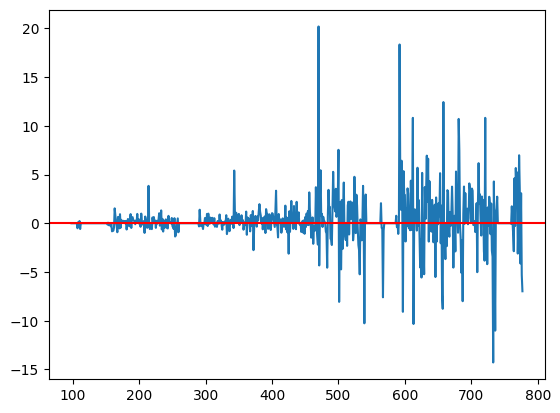

In [40]:
#plotting profit
fb['Profit'].plot()
plt.axhline(y=0, color='red')

In [41]:
#calculating accumalated wealth
fb['wealth'] = fb['Profit'].cumsum()
fb.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA50,Shares,Close1,Profit,wealth
774,2018-01-29,242.740005,248.110001,240.610001,246.850006,246.850006,11377900,233.431003,209.375201,1,242.720001,-4.130005,178.980010
775,2018-01-30,241.110001,246.419998,238.410004,242.720001,242.720001,14270800,235.692003,210.030001,1,245.800003,3.080002,182.060012
776,2018-01-31,245.770004,249.270004,244.449997,245.800003,245.800003,11964400,237.800003,210.713801,1,240.500000,-5.300003,176.760009
777,2018-02-01,238.520004,246.899994,238.059998,240.500000,240.500000,12980600,239.406003,211.296601,1,233.520004,-6.979996,169.780013
778,2018-02-02,237.000000,237.970001,231.169998,233.520004,233.520004,17961600,239.747003,211.685401,1,NaN,NaN,NaN


Text(0.5, 1.0, 'Total money you win is 169.78001300000003')

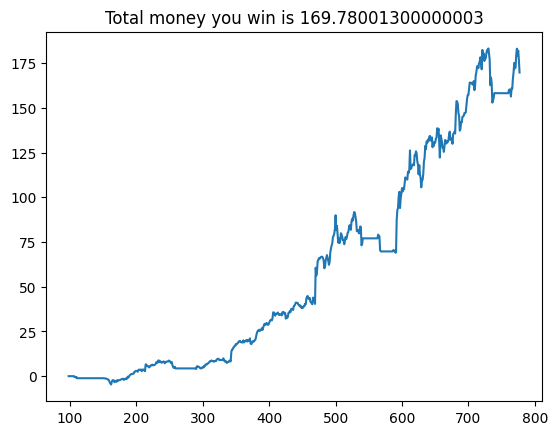

In [42]:
#plotting wealth to show growth of profit
fb['wealth'].plot()
plt.title('Total money you win is {}'.format(fb.loc[fb.index[-2], 'wealth']))

# Models of stock return

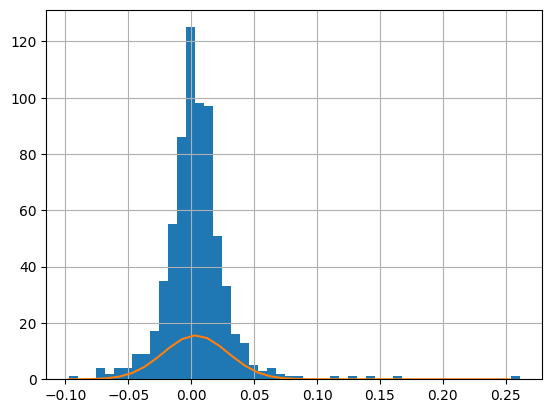

In [43]:
#calculating log returns
fb['log_return'] = np.log(fb['Close1']) - np.log(fb['Close'])
#plotting histogram of log return
mu = fb['log_return'].mean()
sigma = fb['log_return'].std(ddof=1)
density = pd.DataFrame()
density['X'] = np.arange(fb['log_return'].min(), fb['log_return'].max(), 0.01)
density['pdf'] = norm.pdf(density['X'], mu, sigma)
fb['log_return'].hist(bins=50)
plt.plot(density['X'], density['pdf'])
plt.show()

In [44]:
#probability whether stock price would fall in a certain day by 5%
prob_1 = norm.cdf(-0.05, mu, sigma)
print(prob_1)
#probability whether stock price would fall in a certain day by 10%
prob_2 = norm.cdf(-0.1, mu, sigma)
print(prob_2)

0.01815394343675641
2.5821320562235308e-05


In [45]:
#probability that stock price would fall in a year
#there are 220 estimated days in the market in a year
mu220 = 220*mu
sigma220 = (220**0.5)*sigma
prob_year = norm.cdf(-0.2, mu220, sigma220)
print(prob_year)

0.0048445278912097


In [46]:
#calculating value at risk
#single day VaR
#also called 5% quantile (change percentage accordingly)
var = norm.ppf(0.05, mu, sigma)
print(var)

-0.03852429790687481


# Sampling and interference

In [47]:
#sampling and finding statistics of logreturn
sample_size = fb['log_return'].shape[0]
sample_mean = fb['log_return'].mean() #sample mean
sample_std = fb['log_return'].std(ddof=1) #sample standard deviation
sample_sem = fb['log_return'].std(ddof=1) / sample_size**0.5 #sample standard error of mean

#90% confidence interval
#left and right quantile
z_left = norm.ppf(0.05, sample_mean, sample_std)
z_right = norm.ppf(0.95, sample_mean, sample_std)
#upper and lower bound
lower_bound = sample_mean - z_left * sample_std
upper_bound = sample_mean + z_right * sample_std
print("90% Confidence interval is in the interval: ", (lower_bound, upper_bound))

90% Confidence interval is in the interval:  (0.004537585348956945, 0.004719315795579433)


# Hypothesis testing
1. Setting up hypothesis

> H0:μ=0 - Null Hypothesis

> Ha:μ≠0 - Alternate Hypothesis

> H0 means the average stock return is 0 Ha means the average stock return is not equal to 0

2. Calculate test statistic

3. Set decision criteria

4. Make decision - shall we reject H0?

In [48]:
zhat = sample_mean / (sample_std / np.sqrt(sample_size))
print(zhat)

3.6236685873260144


In [49]:
alpha = 0.05 #confidence level
zleft = norm.ppf(alpha/2, 0, 1)
zright = -zleft #zright is negative of zleft
print(zleft, zright)

-1.9599639845400545 1.9599639845400545


In [50]:
print("At significance level {}, should we reject null hypothesis: {} ".format(alpha, zhat>zright or zhat<zleft ))

At significance level 0.05, should we reject null hypothesis: True 


In [51]:
#Alternate method: Checking using pvalue
p = 1 - norm.cdf(zhat, 0, 1)
print(p)

0.00014522686638429594


In [52]:
print("At significance level {}, should we reject null hypothesis: {} ".format(alpha, p<alpha))

At significance level 0.05, should we reject null hypothesis: True 


# Linear regression models for Financial Analysis